In [1]:
%pylab inline
import scipy.stats as stats
import astropy.stats as astats
import numpy.random as random
from astropy.table import Table
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Example of simple linear regression

__Using the below code box, access the documentation for `stats.linregress`.__

__Using the below results, evaluate whether the correlation between the x and y variables is statistically significant.  Why or why not?__

slope: 1.9743 , intercept: 2.9588
rvalue: 0.8031, pvalue: 2.017e-05
std. error in slope: 0.3453


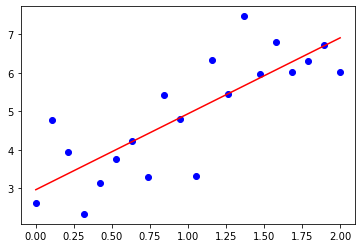

In [2]:
ndata=20
x=np.linspace(0,2,ndata)
y=3+2*x+random.randn(ndata)

slope,intercept,rvalue,pvalue,serr = stats.linregress(x,y)

print(f'slope: {slope:.4f} , intercept: {intercept:.4f}')

# square of Pearson correlation coefficient and p-value for the hypothesis that there is no correlation between the variables.
print(f'rvalue: {rvalue:.4g}, pvalue: {pvalue:.4g}')

# nominal standard error in the slope -- don't trust this!
print(f'std. error in slope: {serr:.4f}')

plt.plot(x,y,'bo')
plt.plot(x,x*slope+intercept,'r-')


Now, let's generate 1000 datasets and evaluate the slope and intercept from each via linear regression:

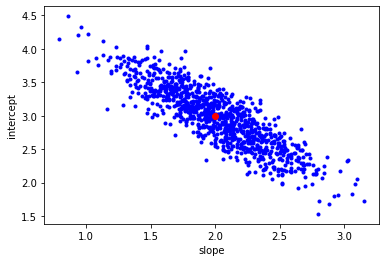

In [3]:
nsims=1000
y=np.zeros((nsims,ndata))
slope=np.zeros(nsims) 
intercept=copy(slope)
serr=copy(slope)

for i in arange(nsims):
    y[i,:]=3+2*x+random.randn(ndata)
    slope_tmp,intercept_tmp,r,p,serr_tmp = stats.linregress(x,y[i,:])
    intercept[i]=intercept_tmp
    slope[i]=slope_tmp
    serr[i]=serr_tmp
plt.plot(slope,intercept,'b.')
plt.xlabel('slope')
plt.ylabel('intercept')
plt.plot(2,3,'ro')

__Using the below code box, determine the standard deviation of the slope values amongst the results from the 1000 datasets, which is stored in an array named `slope`, and compare to the mean estimated standard error in the slope from the fitting routine (those values are stored in the `serr` array).__

__How well do these match in this perfectly specified case?__

__How much does the estimated`serr` value vary from dataset to dataset? (how would you measure that?)__

__What about the slope errors does the `serr` value not capture? (Take a look at the plot above!)__

# Fitting for the Hubble constant with supernovae

We are going to work with the Hicken et al. ("Consitution") supernova dataset.  First, we read in the file into a pandas dataframe named `data`:

In [4]:
# CHANGE THE BELOW LINE TO POINT TO THE DIRECTORY CONTAINING SNDATA.TXT
path = './'  

# the astropy way
#data=Table.read(path+'sndata.txt',format='ascii')

# the pandas way: the file is in "fixed-width format" so we use read_fwf
data=pd.read_fwf(path+'sndata.txt')

__Explore what is in the `data` table using the code box below.__

`data` will print out a nicely formatted version, while `print(data)` will use more basic formatting.



In [5]:
data

,cz,mu,sigma_mu
0,4200.0,34.023,0.254
1,4200.0,33.860,0.260
2,4200.0,34.187,0.257
3,4200.0,33.926,0.253
4,4200.0,34.009,0.251
...,...,...,...
159,22500.0,37.719,0.178
160,22500.0,37.525,0.217
161,23700.0,37.652,0.169
162,25200.0,38.131,0.229


Let's plot distance vs. recession velocity (i.e., the original Hubble's Law), then distance modulus vs. recession velocity:

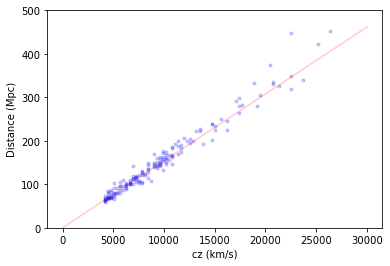

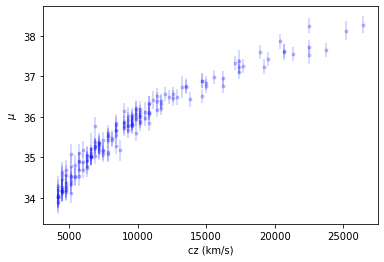

In [6]:
cz=data['cz']
mu=data['mu']
sigma_mu=data['sigma_mu']
d = 10**(mu/5)*1E-5
plt.figure()
plt.plot(cz,d,'b.',alpha=0.2)

plt.xlabel('cz (km/s)')
plt.ylabel(r'Distance (Mpc)')
plt.ylim(0,500)
plt.plot([0,3E4],[0,3E4/65.],'r-',alpha=0.2)

plt.figure()
plt.xlabel('cz (km/s)')
plt.ylabel(r'$\mu$')
plt.errorbar(cz,mu,yerr=sigma_mu,fmt='b.',alpha=0.2)

logv=np.log10(cz)

__Using the below code box, plot mu as a function of logv, with errors.__

## Fit with unweighted least squares

We can use `stats.linregress:`.  __Note that you need to change__ 

`if 0` __to__ 

`if 1` __to get code to execute!__

slope: 5.058 +/- 0.070
intercept: 15.765
H0: 70.31 km/sec/Mpc


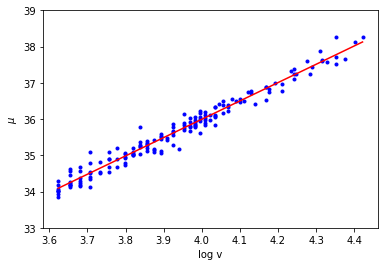

In [7]:
# scipy.stats.linregress: ordinary least-squares regression
slope,intercept,r,p,s = stats.linregress(logv,mu)

# CHANGE 0 TO 1 TO ENABLE THE PLOTS!
if 1:
    plt.plot(logv,mu,'b.')
    plt.ylim(33,39)
    plt.xlabel('log v')
    plt.ylabel(r'$\mu$')
#overplot the fit
    plt.plot(logv,logv*slope+intercept,'r-')
    print(f'slope: {slope:.3f} +/- {s:.3f}')
    print(f'intercept: {intercept:.3f}')
    print(f'H0: {(10**(-0.2*intercept-np.log10(1E-5))):.2f} km/sec/Mpc')

    mu_fit = slope*logv+intercept

### Fit with weighted least squares

The simplest routine we can use is `numpy.polyfit`.  __Look at the documentation for polyfit using the code box below.__  In general, the optimal weights for least squares is $1 \over \sigma_i^2$.

slope: 5.048 +/- 0.071
intercept: 15.798
H0: 69.25 km/sec/Mpc +/- 2.60


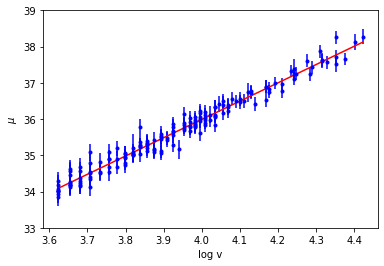

In [8]:
weight = 1./sigma_mu**2


coeffs, covar = np.polyfit(logv,mu,1,w=weight,cov=True)
slope = coeffs[0]
intercept = coeffs[1]
s=np.sqrt(covar[0,0])

# CHANGE 0 TO 1 TO ENABLE THE PLOTS!
if 1:
    plt.errorbar(logv,mu,yerr=sigma_mu,fmt='b.')
    plt.ylim(33,39)
    plt.xlabel('log v')
    plt.ylabel(r'$\mu$')
    plt.plot(logv,logv*slope+intercept,'r-')
    h0err = (10**(-0.2*(intercept-covar[1,1])-np.log10(1E-5)) \
             -10**(-0.2*(intercept+covar[1,1])-np.log10(1E-5)))/2.

    mu_fit_err = slope*logv+intercept

    print(f'slope: {slope:.3f} +/- {s:.3f}')
    print(f'intercept: {intercept:.3f}')
    print(f'H0: {(10**(-0.2*intercept-np.log10(1E-5))):.2f} km/sec/Mpc +/- {h0err:.2f}')



__Are the results from the two methods consistent with our expectations (e.g. consider the slope)?__

Let's examine the scatter about the line, too.  __Examine which method gives smallest scatter about the fit line, and explain why.__


In [9]:
print(f'observed scatter without and with weighting: {np.std(mu - mu_fit):.5f}, {np.std(mu-mu_fit_err):.5f}')
print(f'expected scatter from RMS(sigma_mu): {np.sqrt(np.sum(sigma_mu**2)/len(sigma_mu)):.4f}')
print(f'expected scatter from mean(sigma_mu): {np.mean(sigma_mu):.4f}')
print(f'expected scatter from median(sigma_mu): {np.median(sigma_mu):.4f}')

observed scatter without and with weighting: 0.17900, 0.17901
expected scatter from RMS(sigma_mu): 0.2117
expected scatter from mean(sigma_mu): 0.2096
expected scatter from median(sigma_mu): 0.2020


### Do we see any trends of residual vs. logv?


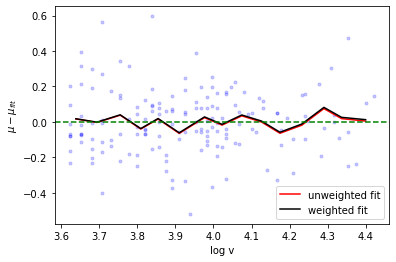

In [37]:

plt.plot(logv, mu-mu_fit,'b.',alpha=0.2)
plt.xlabel('log v')
plt.ylabel(r'$\mu - \mu_{fit}$')


# stats.binned_statistic calculates the chosen statistic
#  on the second array, binned according to the first array
logv_bin,edges,bin_numbers = stats.binned_statistic(logv,logv,statistic='mean', bins=15)

residual_bin,edges,bin_numbers = stats.binned_statistic(logv,mu-mu_fit,
                                    statistic='mean', bins=15)
plt.plot(logv_bin,residual_bin,'r-',label='unweighted fit')

residual_bin_err,edges,bin_numbers = stats.binned_statistic(logv,mu-mu_fit_err,
                                    statistic='mean', bins=15)

plt.plot(logv_bin,residual_bin_err,'k-',label='weighted fit')
plt.legend()
plt.axhline(0,color='g',ls='--')


## Polynomial fits

Let's fit a quadratic using `numpy.polyfit`:

quadratic coefficients [ 0.12223109  4.0676694  17.76049721]
H0: 28.048


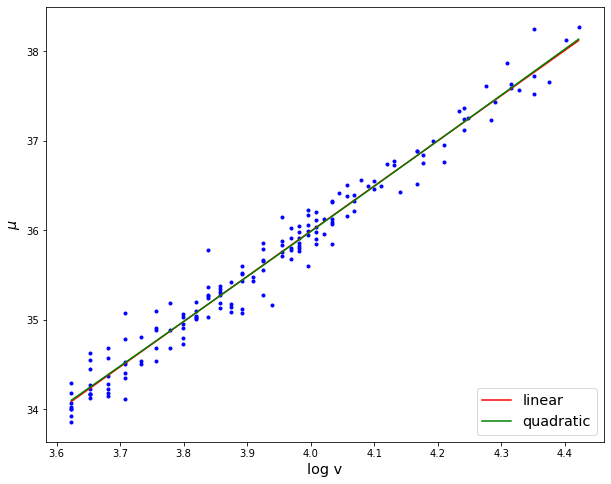

In [38]:
coeffs_quad, covar = np.polyfit(logv,mu,2,w=weight,cov=True)
print('quadratic coefficients', coeffs_quad)
# note the order of the coefficients: the quadratic term is first, constant last

quad_fit = np.polyval(coeffs_quad,logv)

poly_quad = np.poly1d(coeffs_quad)
quad_fit2  = poly_quad(logv)

print(f'H0: {10**(-0.2*coeffs_quad[-1]-np.log10(1E-5)):.3f}')

if 1:
    fig=plt.figure()
        # make figure bigger in hope of being able to see
        # differences between the fits

    fig.set_size_inches(10,8) 
    plt.plot(logv,mu,'b.')
    plt.xlabel('log v',fontsize='x-large')
    plt.ylabel(r'$\mu$',fontsize='x-large')
    plt.plot(logv,mu_fit_err,'r-',label='linear')
    plt.plot(logv,quad_fit,'g-',label='quadratic')
    plt.legend(loc='lower right',fontsize='x-large')



__Enable the plots of the linear and quadratic fits and compare them to each other.__  How much do the curves differ (visually)?  How significant are the differences between the coefficients obtained in each case?  Do you recover the expected slope (i.e., what is the value for the linear term, coeffs[1]?).

__Now, using the code box box below, compute chi-squared from the linear fit (using mu, mu_fit_err & sigma_mu) and from the quadratic fit (using mu, quad_fit, & sigma_mu), and see which has smaller chi-squared.__ Recall $\chi^2 = \Sigma {{(y_i - y_{pred,i})^2} \over \sigma_i^2}$ .

In [35]:
# np.sum((mu-mu_fit)**2/(sigma_mu**2))
np.sum((mu-quad_fit)**2/(sigma_mu**2))

119.84542291061695

### Quartic fit

Now, it's easy to compare to a quartic fit too:


coefficients:  [   1.57960016  -24.60885516  143.58376141 -366.83484566  376.57698941]
H0: 0.000
chi squared - quartic: 119.644


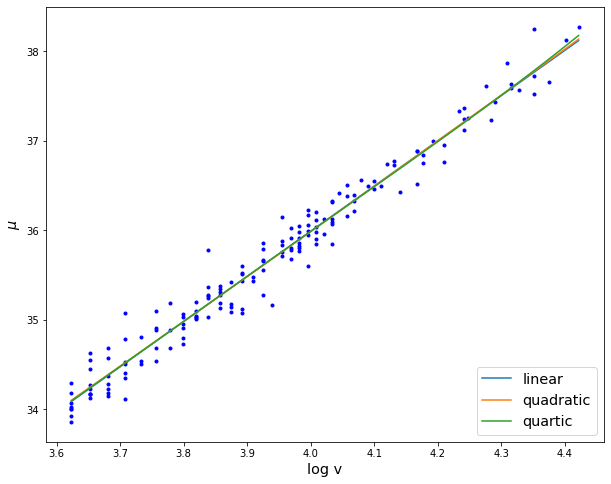

In [39]:
coeffs_quart, covar = np.polyfit(logv,mu,4,w=weight,cov=True)
poly_quart = np.poly1d(coeffs_quart)
quart_fit = poly_quart(logv)
print('coefficients: ', coeffs_quart)
print(f'H0: {10**(-0.2*coeffs_quart[-1]-np.log10(1E-5)):.3f}')

print(f'chi squared - quartic: {np.sum((mu-quart_fit)**2/sigma_mu**2):.3f}')

if 1:   
    fig=plt.figure()
    fig.set_size_inches(10,8)
    plt.plot(logv,mu,'b.')
    plt.xlabel('log v',fontsize='x-large')
    plt.ylabel(r'$\mu$',fontsize='x-large')
    plt.plot(logv,mu_fit_err,label='linear')
    plt.plot(logv,quad_fit,label='quadratic')
    plt.plot(logv,quart_fit,label='quartic')
    plt.legend(loc='lower right',fontsize='x-large')

### Examining the residuals

__Are the residuals getting smaller as we increase the polynomial's order?  Do a quantitative test of this after the code to make the below plot.__

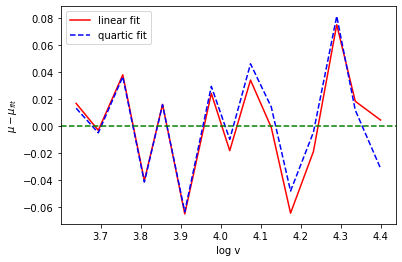

In [40]:
residual_bin_quart,edges,bin_numbers = stats.binned_statistic(logv,mu-quart_fit,
                                statistic='mean', bins=15)
plt.plot(logv_bin,residual_bin,'r-',label='linear fit')
plt.xlabel('log v')
plt.ylabel(r'$\mu - \mu_{fit}$')
plt.plot(logv_bin,residual_bin_quart,'b--',label='quartic fit')
plt.legend()

plt.axhline(0,color='g',ls='--')


__How well do the fits extrapolate?  Compare the results for the linear, quadratic and quartic fits to the below plot.__  



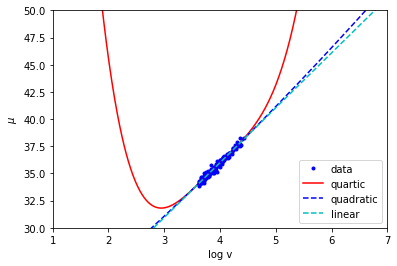

In [43]:
poly_lin = np.poly1d(coeffs)
x=np.linspace(0,10,1000)
plt.plot(logv,mu,'b.',label='data')
plt.xlim((1,7))
plt.ylim( (30,50))
plt.xlabel('log v')
plt.ylabel(r'$\mu$')
plt.plot(x,poly_quart(x),'r-',label='quartic')
plt.plot(x,poly_quad(x),'b--',label='quadratic')

plt.plot(x,poly_lin(x),'c--',label='linear')

plt.legend()

## Which fits have an acceptable chi-squared?

__Based on the following, assess which models are consistent with the data: i.e., is any statistically significant difference from the model observed?__

In [44]:
chisq_lin=np.sum( (mu - mu_fit_err)**2/sigma_mu**2)
chisq_q=np.sum( (mu - quart_fit)**2/sigma_mu**2)

print(f'chi-squared for linear: {chisq_lin:.3f}')
print(f'chi-squared for quartic: {chisq_q:.3f}')
print(f'difference: {chisq_lin-chisq_q:.3f}')

print()
print(f'alpha=0.05 chi-squared cutoff for linear: {stats.chi2.ppf(.95,162):.3f}')
print(f'alpha=0.05 chi-squared cutoff for quartic: {stats.chi2.ppf(.95,159):.3f}')

print()
print(f'p-value for linear: {1-stats.chi2.cdf(chisq_lin,162):.3g}')
print(f'p-value for quartic: {1-stats.chi2.cdf(chisq_q,159):.3g}')



chi-squared for linear: 120.033
chi-squared for quartic: 119.644
difference: 0.390

alpha=0.05 chi-squared cutoff for linear: 192.700
alpha=0.05 chi-squared cutoff for quartic: 189.424

p-value for linear: 0.994
p-value for quartic: 0.991


# Calculating information criteria

$BIC = -2~\ln{L_{max}} + k\ln{n} = \chi^2 + k \ln{n}$

$AIC = -2~\ln{L_{max}} + 2 k  +2k(k+1)/(n-k-1) = \chi^2 +2 k  +2k(k+1)/(n-k-1)$

In [45]:
bic_lin = chisq_lin+2*np.log(len(logv))
bic_q = chisq_q+4*np.log(len(logv))

print(f'BIC: linear    {bic_lin:.3f}')
print(f'BIC: quadratic {bic_q:.3f}')

print()

k=2
aic_lin = chisq_lin+2*k+2*k*(k+1)/(len(logv)-k-1)
k=4
aic_q = chisq_q+2*k+2*k*(k+1)/(len(logv)-k-1)

print(f'AIC: linear    {aic_lin:.3f}')
print(f'AIC: quadratic {aic_q:.3f}')

BIC: linear    130.233
BIC: quadratic 140.043

AIC: linear    124.108
AIC: quadratic 127.895


# Getting bootstrap error estimates

For bootstrapping regression errors, we want to bootstrap amongst the (x,y) pairs, while keeping the values matched up to each other.  I.e.: if we draw x[5] for a particular bootstrap set, we use y[5] as the corresponding y value.  This means we will want to generate random sets of _indices_ to address multiple arrays, rather than using `np.random.choice()` on a single array.

In [48]:
# we will generate nsims different bootstrap samples, 
#  each the same size as the original array

nsims=int(1E3)
n=len(mu)

# generate an nsims x n array of numbers ranging from 0 to n-1: 
#    these will correspond to indices in the original array
# so if bootidx[j,i] = 5, for the j'th simulation, the i'th x/y pair 
#    will correspond to supernova index 5 in the original array
bootidx=np.floor(random.rand(nsims,n)*n)
bootidx=bootidx.astype(int)

# we will need to convert pandas series to numpy arrays to make 2d 
#   bootstrap arrays: we want to take the value of each array
#   at our generated index number

logv_boot=logv.ravel()[bootidx]
mu_boot=mu.ravel()[bootidx]
w_boot=weight.ravel()[bootidx]
slope=np.zeros(nsims)
intercept=np.copy(slope)

for i in arange(nsims):
    coeffs = np.polyfit(logv_boot[i,:],mu_boot[i,:],1,w=w_boot[i,:])
    intercept[i]=coeffs[1]
    slope[i]=coeffs[0]


In the below figures, we plot the slope and intercept (or the H0 value) derived from each bootstrap sample.  __Add a points to the first figure and a vertical line to the second indicating the result of our original linear fit.  How does it compare?__

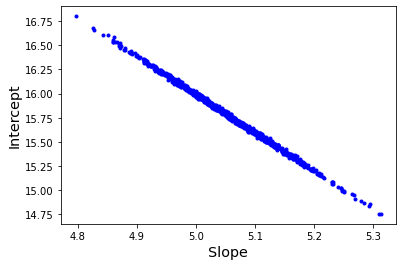

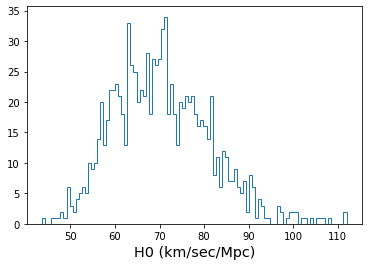

In [47]:
if 1:
    plt.figure()
    plt.plot(slope,intercept,'b.')
    plt.xlabel('Slope',fontsize='x-large')
    plt.ylabel('Intercept',fontsize='x-large')


    plt.figure()
    h0=10**(-0.2*intercept-np.log10(1E-5))
    n,bins,edges=plt.hist(h0,bins=100,histtype='step')
    plt.xlabel('H0 (km/sec/Mpc)',fontsize='x-large')


### A note

__Distance moduli for the supernovae from Hicken et al. were produced assuming that locally $H_0$ = 65 km/sec/Mpc.  How does that compare to your results?__